# ML Modeling

In this 3rd and final section of the notebook I will preprocces my data, train and test multiple ML models, to identify the best one to answer the research question of this project.

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass

In [53]:
password = getpass.getpass()

········


# Loading the data

In [55]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/LendingClub'
engine = create_engine(connection_string)
query = '''SELECT *
FROM LendingClub.loans'''

df = pd.read_sql_query(query, engine)
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_income,verification_status,loan_status,purpose,...,dti,delinq_2yrs,inq_last_6mths,open_accounts,pub_rec_derogatory,revol_balance,revol_util_rate,total_accounts,pub_rec_bankruptcies,years_succes_loans
0,5000,36 months,0.1065,162.87,B2,RENT,24000,Verified,0,credit_card,...,0.2765,0.0,1.0,3.0,0.0,13648.0,0.837,9.0,0.0,31
1,2500,60 months,0.1527,59.83,C4,RENT,30000,Source Verified,1,car,...,0.0100,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,0.0,17
2,2400,36 months,0.1596,84.33,C5,RENT,12252,Not Verified,0,small_business,...,0.0872,0.0,2.0,2.0,0.0,2956.0,0.985,10.0,0.0,15
3,10000,36 months,0.1349,339.31,C1,RENT,49200,Source Verified,0,other,...,0.2000,0.0,1.0,10.0,0.0,5598.0,0.210,37.0,0.0,20
4,5000,36 months,0.0790,156.46,A4,RENT,36000,Source Verified,0,leisure,...,0.1120,0.0,3.0,9.0,0.0,7963.0,0.283,12.0,0.0,12


# Checking & transforming distributions

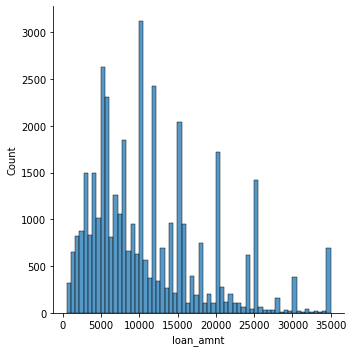

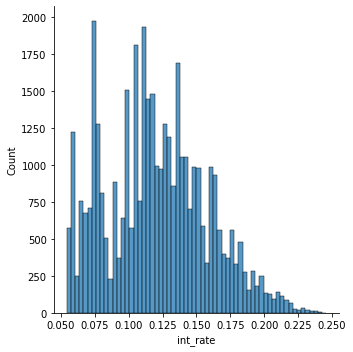

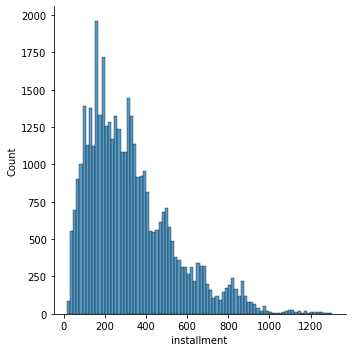

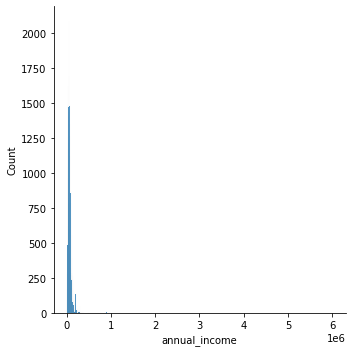

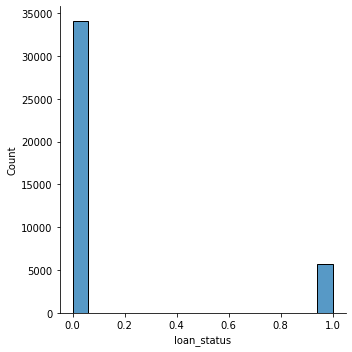

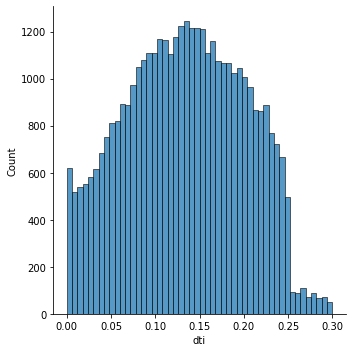

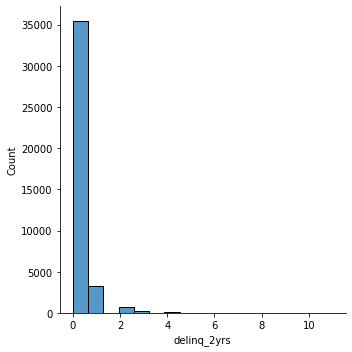

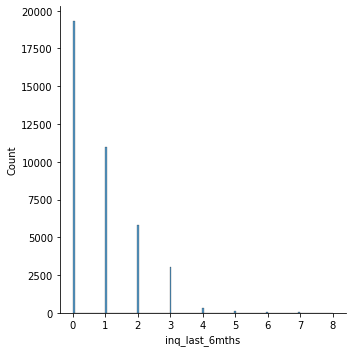

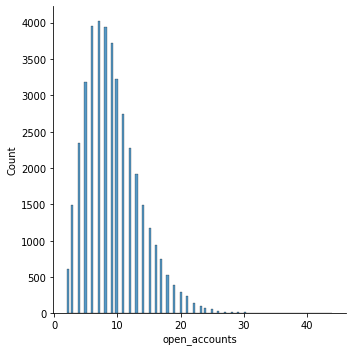

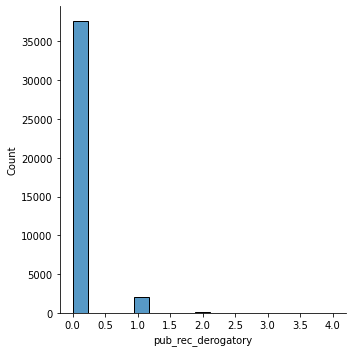

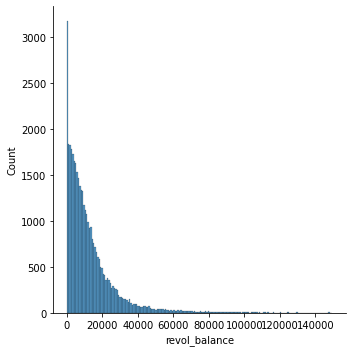

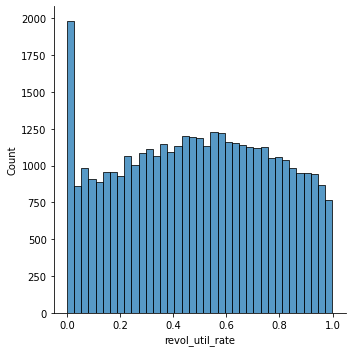

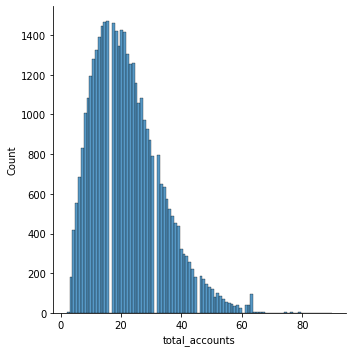

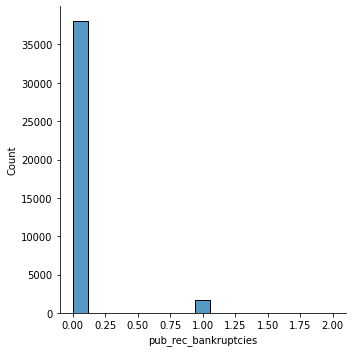

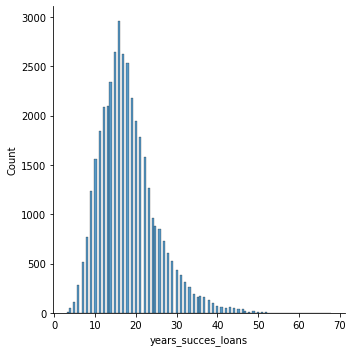

In [57]:
# plotting the numerical variables
# the plots below show some interesting info: DTI is close to being normally distributed
# Installment, int_rate, loan_amnt are a little bit normally distribute with a right skew
# annual_income is very heavily skewed to the right, there has to be some outliers in here
# revol_balance is exponentially distributed 
# revol_util_rate is pretty evenly distributed with a slight normally distributed curve, however there are a lot of 0's here. 
# this quite intersting as this means there is a big group of members that are currently not using any of their available credit.

def displot_num(df):
    for c in df:
        sns.displot(x=c, data=df)
        plt.show()
    return None

displot_num(df.select_dtypes(include=np.number))

In [5]:
# As loan_amnt, annual_income and revol_balance have values spread out over a big range and are pretty skewed I will log transform them
def log_transform(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN

df['loan_amnt'] = df['loan_amnt'].apply(log_transform)
df['annual_income'] = df['annual_income'].apply(log_transform)
df['revol_balance'] = df['revol_balance'].apply(log_transform)

In [6]:
df['revol_balance'] = df['revol_balance'].fillna(np.mean(df['revol_balance']))

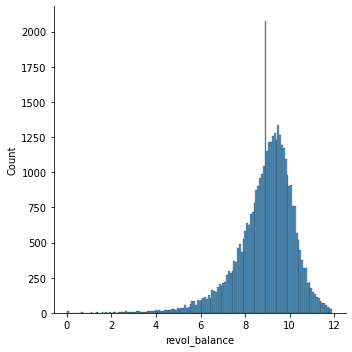

In [7]:
sns.displot(x='revol_balance', data=df)
plt.show()

# Checking for multicolinearty

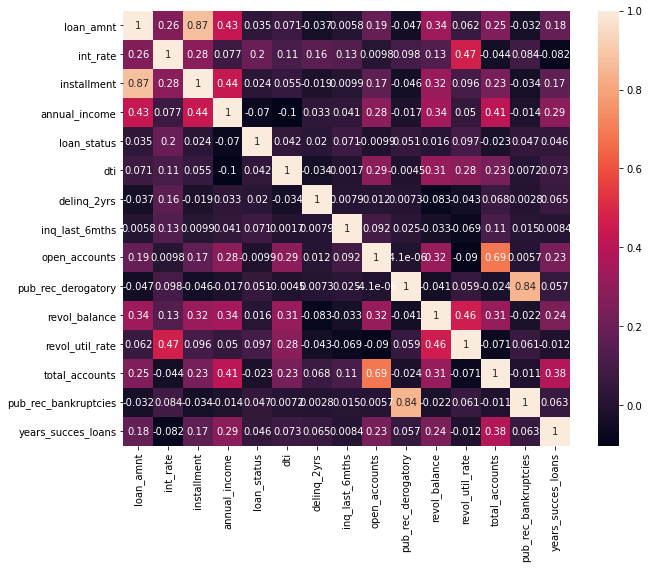

In [9]:
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [10]:
df['pub_rec_derogatory'].value_counts()

0.0    37627
1.0     2059
2.0       51
3.0        8
4.0        2
Name: pub_rec_derogatory, dtype: int64

In [11]:
df['pub_rec_bankruptcies'].value_counts()

0.0    38063
1.0     1677
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [12]:
# looking at the correlation matrix above we can see that installment and loan_amnt are highly correlated with each other
# This makes sense because the installement is the monthly payment the member has to pay based on their loan amount. 
# this means there is multicolinearity, thus one of the columns has to go. 
# because the installment is a set rate based on the term and the loan amount, we can drop this column as we essentially also have this information in the loan amount and term
df = df.drop(['installment'],axis=1)

#Also 'open_accounts' & 'total_accounts' and 'pub_rec_derogatory' & 'rec_bankruptcy' correlate with each other.
#dropping 'open_accounts' as 'total_accounts' contains the number of 'open_accounts' as well
#dropping 'rec_bankruptcy' because is very little knownn about, and 'pub_rec_derogatory' also contains the information of 'rec_bankruptcy'. 
df = df.drop(['pub_rec_bankruptcies','open_accounts'],axis=1)

# Hypothesis Testing - Categorical multicolinearity

In order to check for multicolinearity between categorical variables, I use the Chi2 score contingency to find the P-value showing me if can reject H0(there is no relationship) or not. 

In [59]:
# H0: Columns 'purpose' and 'term' are independent
# H1: Columns 'purpose' and 'term' are NOT independent
import scipy.stats as st

data_crosstab = pd.crosstab(df['purpose'], df['term'], margins = False)
st.chi2_contingency(data_crosstab)

(486.78724498394314,
 3.874316085444531e-99,
 9,
 array([[ 1135.37867009,   415.62132991],
        [ 3756.77842353,  1375.22157647],
        [13653.09321458,  4997.90678542],
        [  237.90977935,    87.09022065],
        [ 2966.18592598,  1085.81407402],
        [  972.86799004,   356.13200996],
        [ 1600.94980753,   586.05019247],
        [  508.76091277,   186.23908723],
        [ 2926.6563011 ,  1071.3436989 ],
        [ 1337.41897502,   489.58102498]]))

In [60]:
# H0: Columns 'verification_status' and 'home_ownership' are independent
# H1: Columns 'verification_status' and 'home_ownership' are NOT independent
import scipy.stats as st

data_crosstab = pd.crosstab(df['verification_status'], df['home_ownership'], margins = False)
st.chi2_contingency(data_crosstab)

(463.02679712844093,
 7.706949665685216e-97,
 6,
 array([[7530.1325383 ,   43.00256623, 1304.12733036, 8045.7375651 ],
        [4451.42385589,   25.42088711,  770.93244773, 4756.22280927],
        [5704.44360581,   32.57654666,  987.9402219 , 6095.03962563]]))

In both hypothesis, H0 has to be rejected as we get a p-value of lower than 0.05. This means that there is some sort of multicolinearity. However this score does not tell us how highly both values correlate. I actually checked all my categorical variables (but left this out for space sake) and all correlate with each other in someway. As I feel the categorical variables are too important to drop and the correlation is probably so low that they won't impact the model, I decided to keep all of my categorical variables. 

# Preparing the data: X-Y split, Scaling and Encoding

In [14]:
#making X-Y split
X = df.drop(['loan_status'],axis=1)
y = df['loan_status']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
#cat/num X-train
#make a split between the continuous and discrete variables as I don't want to scale or encode the discrete ones, I want to keep their current values
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(object)

#cat/num X-test
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(object)


from sklearn.preprocessing import StandardScaler
#Scale X-train
transformer = StandardScaler().fit(X_train_num)
X_scaled_train = pd.DataFrame(transformer.transform(X_train_num),columns=X_train_num.columns)

#Scale X-test
X_scaled_test = pd.DataFrame(transformer.transform(X_test_num),columns=X_test_num.columns)
X_scaled_test

,loan_amnt,int_rate,annual_income,dti,delinq_2yrs,inq_last_6mths,pub_rec_derogatory,revol_balance,revol_util_rate,total_accounts,years_succes_loans
0,-1.225438,-0.642333,-2.817657,-0.938280,-0.296059,-0.811776,3.964092,-2.079635,-0.523182,-0.704322,0.272528
1,0.419341,0.483261,1.170272,-0.875506,1.734246,0.127124,-0.235633,-0.194156,-0.158717,0.523152,-0.578297
2,-0.134576,-1.215902,0.198797,0.321674,1.734246,-0.811776,-0.235633,0.617298,0.616213,-0.002909,-0.294689
3,-0.418237,1.495757,-1.510063,0.193138,-0.296059,1.066023,-0.235633,0.429562,1.702531,-0.616646,-0.861905
4,-1.474513,-0.039144,-0.664299,-0.945753,-0.296059,0.127124,-0.235633,-1.392817,-0.314411,0.961535,0.556136
...,...,...,...,...,...,...,...,...,...,...,...
11920,0.419341,-0.241105,1.118435,-1.403103,-0.296059,2.943822,-0.235633,-1.369916,-1.517499,1.136889,0.130724
11921,0.100193,-0.437680,0.055886,0.054140,-0.296059,-0.811776,-0.235633,1.416456,0.007592,0.610828,1.406960
11922,1.247399,1.161849,0.468521,0.208084,-0.296059,0.127124,-0.235633,1.104819,1.054987,0.786182,0.556136
11923,1.117193,-1.215902,0.055886,2.053925,-0.296059,-0.811776,-0.235633,0.544141,-1.053957,1.487595,1.690568


In [18]:
from sklearn.preprocessing import OneHotEncoder
# Onehot encoding
encoder = OneHotEncoder().fit(X_train_cat)

# encode training data
train_encoded = encoder.transform(X_train_cat).toarray()

train_encoded_columns = list()
train_dropped_columns = list()

for columns in encoder.categories_:
    condition = True
    for column in columns.tolist():
        if condition:
            train_dropped_columns.append(column)
            train_encoded_columns.append(column)
            condition = False
        else:
            train_encoded_columns.append(column)

train_cat_encoded = pd.DataFrame(data = train_encoded, columns=train_encoded_columns)
train_cat_encoded = train_cat_encoded.drop(columns = train_dropped_columns)
train_cat_encoded.head()

,60 months,A2,A3,A4,A5,B1,B2,B3,B4,B5,...,home_improvement,leisure,major_purchase,medical,other,small_business,Northeast,Southeast,Southwest,West
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
# encode test data
test_encoded = encoder.transform(X_test_cat).toarray()

test_encoded_columns = list()
test_dropped_columns = list()

for columns in encoder.categories_:
    condition = True
    for column in columns.tolist():
        if condition:
            test_dropped_columns.append(column)
            test_encoded_columns.append(column)
            condition = False
        else:
            test_encoded_columns.append(column)

test_cat_encoded = pd.DataFrame(data = test_encoded, columns=test_encoded_columns)
test_cat_encoded = test_cat_encoded.drop(columns = test_dropped_columns)
test_cat_encoded

,60 months,A2,A3,A4,A5,B1,B2,B3,B4,B5,...,home_improvement,leisure,major_purchase,medical,other,small_business,Northeast,Southeast,Southwest,West
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11920,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11921,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
11922,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
#merging the data and training set with encoded, scaled and discrete values
# Training data first
X_train_nrml = pd.concat([X_scaled_train,train_cat_encoded], axis = 1)
X_train_nrml

,loan_amnt,int_rate,annual_income,dti,delinq_2yrs,inq_last_6mths,pub_rec_derogatory,revol_balance,revol_util_rate,total_accounts,...,home_improvement,leisure,major_purchase,medical,other,small_business,Northeast,Southeast,Southwest,West
0,0.026331,-0.381131,-0.067296,-0.735013,-0.296059,0.127124,-0.235633,0.247258,-0.133948,-0.090585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.081503,-0.273419,-0.668223,-1.437479,-0.296059,-0.811776,-0.235633,-0.420241,0.598521,-0.967353,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.081503,-0.825444,-1.870256,-1.404598,-0.296059,-0.811776,-0.235633,-1.449493,-1.036264,-0.616646,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.422035,-0.004138,-0.342522,-1.580961,-0.296059,2.004922,-0.235633,-0.751487,-1.475037,0.260121,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.532654,0.695993,0.547065,-0.202933,3.764551,-0.811776,3.964092,0.033500,0.870985,-0.353616,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27817,-2.028429,0.609823,-1.011511,-0.788819,-0.296059,-0.811776,-0.235633,-1.060346,1.069141,0.172445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27818,-0.776660,0.534424,0.226056,1.490458,-0.296059,0.127124,-0.235633,-2.146476,1.575145,0.084768,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
27819,1.117193,0.278607,0.895046,0.100472,-0.296059,0.127124,-0.235633,-1.430137,-0.937186,-1.493413,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
27820,-2.726282,0.184359,-0.958211,0.019764,-0.296059,0.127124,-0.235633,0.150261,1.610530,0.698505,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
#merging test data
X_test_nrml = pd.concat([X_scaled_test,test_cat_encoded], axis = 1)


# Model selection

In order to best predict loan defaults and what features influence that, I trained multiple ML models to see which one scores the best. I am focussing mainly on the Recall score here as this shows the amount of loans that are wrongfully identified as paid off, as they actually default. The higher the recall the lower this amount is, which is the goal of this project.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

## Logistic Regression - No weights

accuracy: 0.8574423480083857
precision:  0.47692307692307695
recall:  0.018267530936947555
f1:  0.03518728717366629


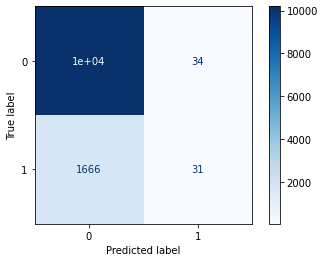

In [23]:
LR = LogisticRegression(random_state=42, solver='lbfgs', max_iter=4000).fit(X_train_nrml, y_train)
pred = LR.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, pred))
print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

plot_confusion_matrix(LR, X_test_nrml, y_test,cmap=plt.cm.Blues)  
plt.show()

This model shows a very low Recall score, this can be explained due to the heavy imbalance in the dataset. 

## Logistic Regression - Balanced Weights

In an attempt to try and improve the model above, I add the 'balanced class_weights' to deal with the imbalance. 

In [24]:
LR_balanced = LogisticRegression(random_state=42, solver='lbfgs', max_iter=4000,class_weight='balanced').fit(X_train_nrml, y_train)
pred_balanced = LR_balanced.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, pred_balanced))
print("precision: ",precision_score(y_test,pred_balanced))
print("recall: ",recall_score(y_test,pred_balanced))
print("f1: ",f1_score(y_test,pred_balanced))

accuracy: 0.6482180293501049
precision:  0.23683101559207753
recall:  0.6623453152622275
f1:  0.3489057892286202


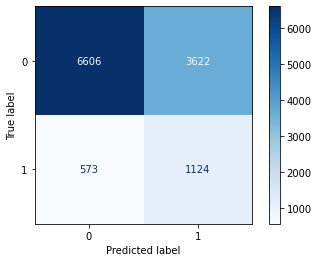

In [25]:
plot_confusion_matrix(LR_balanced, X_test_nrml, y_test,cmap=plt.cm.Blues)  
plt.show()

The recall has increased a lot by adding the balanced weights, giving us a way more accurate model for the research question we are trying to answer.  

## Logistic Regression - Manual Weights

In an attempt to improve this score as well, I add manual weights to find the sweet spot between the lowest amount of defaults, while not losing all the 'good' loans. 

In [26]:
weight = {1: 0.87,
           0: 0.13
          }
LR_manual = LogisticRegression(random_state=1, solver='lbfgs', max_iter=4000,class_weight=weight).fit(X_train_nrml, y_train)
pred_manual = LR_manual.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, pred_manual))
print("precision: ",precision_score(y_test,pred_manual))
print("recall: ",recall_score(y_test,pred_manual))
print("f1: ",f1_score(y_test,pred_manual))

accuracy: 0.6149266247379455
precision:  0.22673211251651879
recall:  0.7077195050088392
f1:  0.34343723191306835


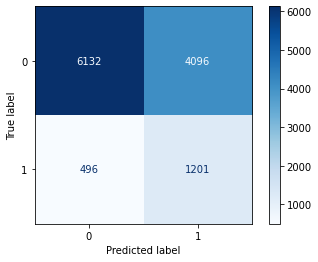

In [27]:
plot_confusion_matrix(LR_manual, X_test_nrml, y_test,cmap=plt.cm.Blues)  
plt.show()

## Trying different models 

As there are more models than only Logistic Regression, I am trying them out below to get a better score. 

## KNNeighbors

In [28]:
from sklearn import neighbors
KNN = neighbors.KNeighborsClassifier(n_neighbors=25, weights='distance').fit(X_train_nrml, y_train)
predictions_KNN = KNN.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, predictions_KNN))
print("precision: ",precision_score(y_test,predictions_KNN))
print("recall: ",recall_score(y_test,predictions_KNN))
print("f1: ",f1_score(y_test,predictions_KNN))

accuracy: 0.8568553459119497
precision:  0.3333333333333333
recall:  0.0058927519151443725
f1:  0.011580775911986103


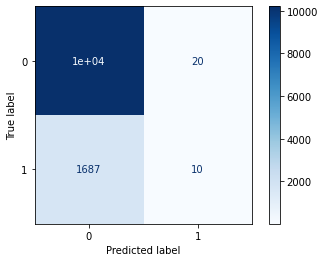

In [29]:
plot_confusion_matrix(KNN, X_test_nrml, y_test,cmap=plt.cm.Blues)  
plt.show()

## SMOTE

In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100,k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_nrml,y_train)

smote = LogisticRegression(random_state=42,max_iter=1000).fit(X_train_SMOTE, y_train_SMOTE)
pred_smote = smote.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, pred_smote))
print("precision: ",precision_score(y_test,pred_smote))
print("recall: ",recall_score(y_test,pred_smote))
print("f1: ",f1_score(y_test,pred_smote))

accuracy: 0.6420125786163522
precision:  0.23230641132389676
recall:  0.657631113730112
f1:  0.34333179510844486


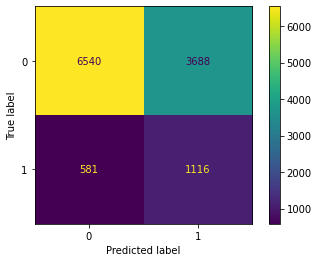

In [31]:
plot_confusion_matrix(smote, X_test_nrml, y_test)  
plt.show()

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
smt2 = SMOTE()
X_train_smt, y_train_smt = smt2.fit_resample(X_train_nrml, y_train)
smt_Rf = RandomForestClassifier(random_state=42).fit(X_train_smt, y_train_smt)

pred_smt_RF = smt_Rf.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, pred_smt_RF))
print("precision: ",precision_score(y_test,pred_smt_RF))
print("recall: ",recall_score(y_test,pred_smt_RF))
print("f1: ",f1_score(y_test,pred_smt_RF))

accuracy: 0.849895178197065
precision:  0.3485342019543974
recall:  0.06305244549204478
f1:  0.10678642714570859


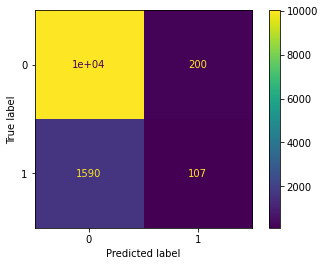

In [33]:
plot_confusion_matrix(smt_Rf, X_test_nrml, y_test)  
plt.show()

## Undersampling

In [40]:
X_train_nrml = X_train_nrml.reset_index()
y_train = y_train.reset_index()
train = pd.concat([X_train_nrml, y_train],axis=1)
fully_paid = train[train['loan_status']==0]
charged_off = train[train['loan_status']==1]

In [41]:
from sklearn.utils import resample
fullypaid_undersampled = resample(fully_paid, 
                                    replace=False,
                                    n_samples = len(charged_off),
                                    random_state=42)


display(charged_off.shape)
display(fullypaid_undersampled.shape)

(3965, 67)

(3965, 67)

In [42]:
train_undersampled = pd.concat([fullypaid_undersampled,charged_off])

In [43]:
y_train_under = train_undersampled['loan_status'].copy()
X_train_under = train_undersampled.drop('loan_status',axis = 1).copy()

In [44]:
X_train_under = X_train_under.drop(['index'],axis=1)

## Undersampling - Logistic Regression

In [45]:
LR_under = LogisticRegression(max_iter=1000).fit(X_train_under, y_train_under)
pred_under = LR_under.predict(X_test_nrml)

print('accuracy:', accuracy_score(y_test, pred_under))
print("precision: ",precision_score(y_test,pred_under))
print("recall: ",recall_score(y_test,pred_under))
print("f1: ",f1_score(y_test,pred_under))

accuracy: 0.6520754716981132
precision:  0.23769790329482243
recall:  0.6546847377725398
f1:  0.34876785433997803


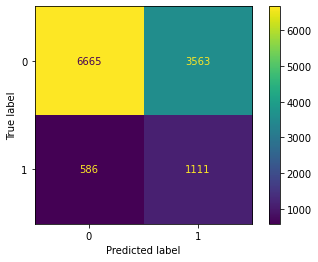

In [47]:
plot_confusion_matrix(LR_under, X_test_nrml, y_test)  
plt.show()

Using this combination of undersampling and Logistic Regression essentially gives me the same Recall score as using 'balanced class_weights' in the logistic regression. This is an interesting find as using class_weights is a much faster and easier way to get the same results. 

## Undersampling - Random Forest

In [48]:
RF_under = RandomForestClassifier(random_state=42).fit(X_train_under, y_train_under)

pred_RF_under = RF_under.predict(X_test_nrml)

In [49]:
print('accuracy:', accuracy_score(y_test, pred_RF_under))
print("precision: ",precision_score(y_test,pred_RF_under))
print("recall: ",recall_score(y_test,pred_RF_under))
print("f1: ",f1_score(y_test,pred_RF_under))

accuracy: 0.6446960167714885
precision:  0.23364093959731544
recall:  0.6564525633470831
f1:  0.34462490332559936


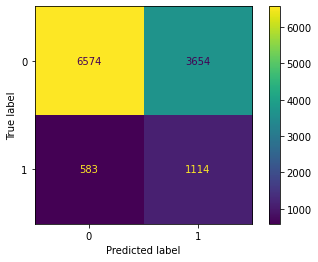

In [50]:
plot_confusion_matrix(RF_under, X_test_nrml, y_test)  
plt.show()

## Identifying the best model

As we try to minimize the amount of defaults, we need to have the lowest number possible in the matrix, where the model falsely predicts someone is going to pay off their loan when they actually don't. The best matrix to indicate the lowest amount of false fully paid loans is recall. To compare our models I am going to reprint the recall of all the models I tried out. 

In [51]:
print("LR-no weights-recall: ",recall_score(y_test,pred))
print("LR-balanced weights-recall: ",recall_score(y_test,pred_balanced))
print("LR-manual weights-recall: ",recall_score(y_test,pred_manual))
print("LR-KNN-recall: ",recall_score(y_test,predictions_KNN))
print("LR-SMOTE-recall: ",recall_score(y_test,pred_smote))
print("LR-Random Forest-recall: ",recall_score(y_test,pred_smt_RF))
print("LR-Undersample LR-recall: ",recall_score(y_test,pred_under))
print("LR-Undersample RF-recall: ",recall_score(y_test,pred_RF_under))

LR-no weights-recall:  0.018267530936947555
LR-balanced weights-recall:  0.6623453152622275
LR-manual weights-recall:  0.7077195050088392
LR-KNN-recall:  0.0058927519151443725
LR-SMOTE-recall:  0.657631113730112
LR-Random Forest-recall:  0.06305244549204478
LR-Undersample LR-recall:  0.6546847377725398
LR-Undersample RF-recall:  0.6564525633470831


Above shows us that the Logistic Regression model with manual weights gives us the best Recall score. This is therefore, given my research question, the best model to go with. However, it should be noted that the higher the recall, the lower the accuracy and precision is in this case. This means that the stricter we get with approving new loans, the higher the number of good loans we are missing too, which is a loss of money as well. If I had further financial information I could calculate what the loss and gain of money of every model is to make a better informed decision. However, with the information I have now, it's clear that the lowest possible number of defaults (while not losing the majority of loans) is the outcome in the project. As loss of reputation and trust of investors can have disastrous concequences for the lending club.

## Feature importance 

Luckily, the ML model is not the final step we can take to identify defaulters. To get a better and more detailed insight in the features of members that default, I made feature importance model. 

In [35]:
feature_imp=pd.DataFrame({'feature':list(X_train_nrml.columns),'feature_importance':[abs(i) for i in LR_manual.coef_[0]]})
feature_imp.sort_values('feature_importance',ascending=False)

,feature,feature_importance
59,small_business,0.798443
40,F5,0.634429
1,int_rate,0.477692
11,60 months,0.467109
46,OTHER,0.409019
...,...,...
47,OWN,0.020719
9,total_accounts,0.019888
7,revol_balance,0.018226
37,F2,0.009735


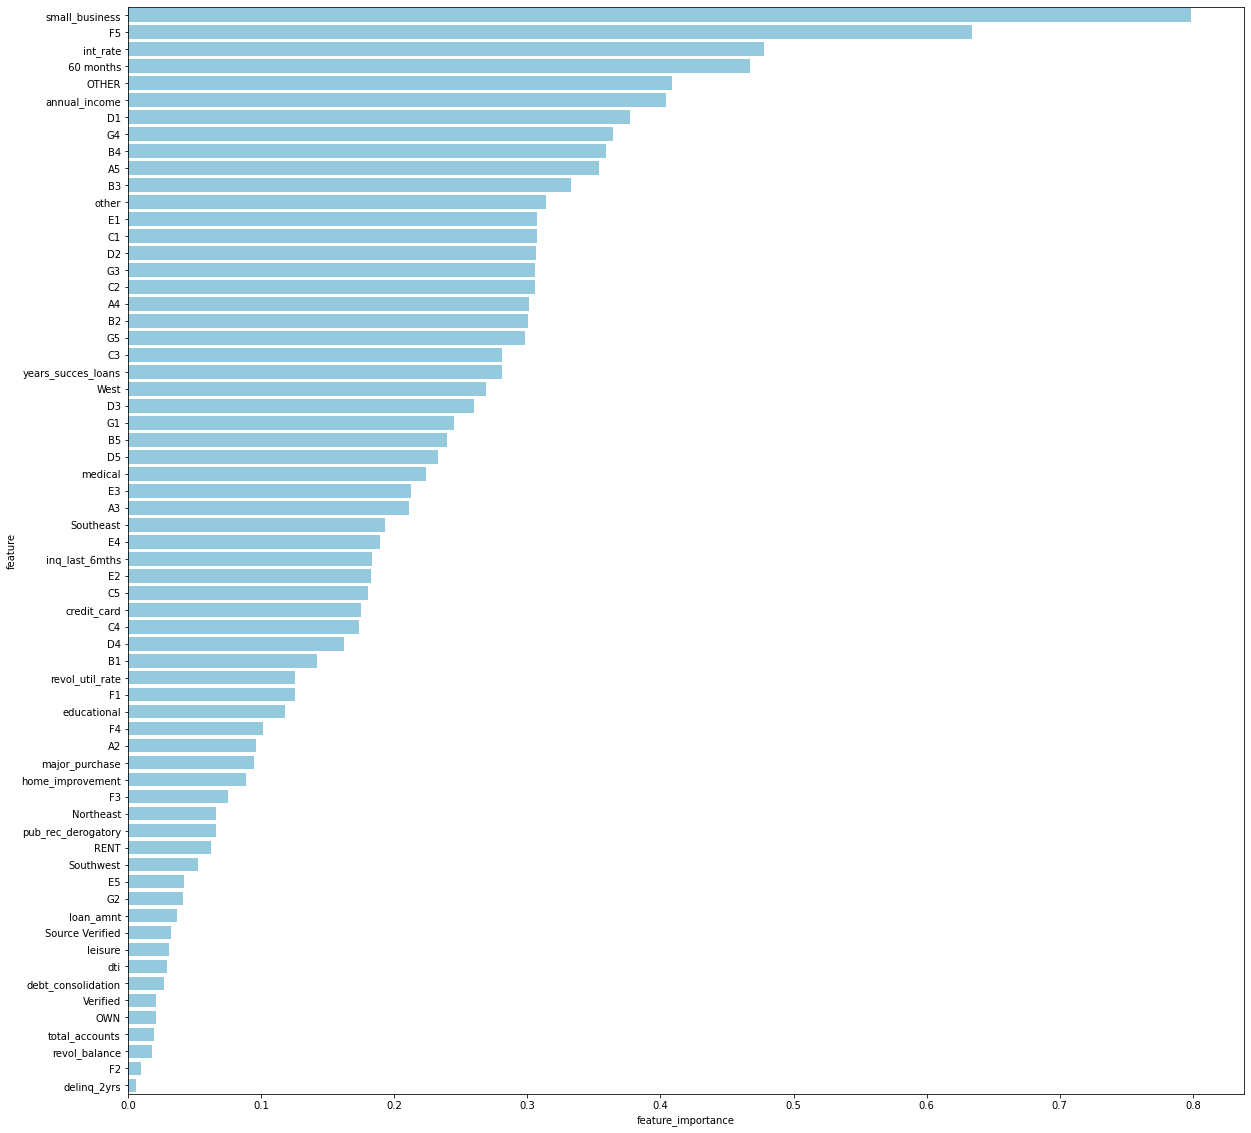

In [36]:
plt.figure(figsize=(20,20))
sns.barplot(x="feature_importance", y="feature", data=feature_imp,color = 'skyblue',order=feature_imp.sort_values('feature_importance',ascending=False).feature)
plt.show()

In [37]:
#as not all features have that big an impact on the predictions in the model, I am slicing the features to the top 12 that have the biggest impact on the predictions, as after these 12 it evens out a bit more
feature_importance_top12 = feature_imp.sort_values('feature_importance',ascending=False).reset_index().iloc[0:12,:]

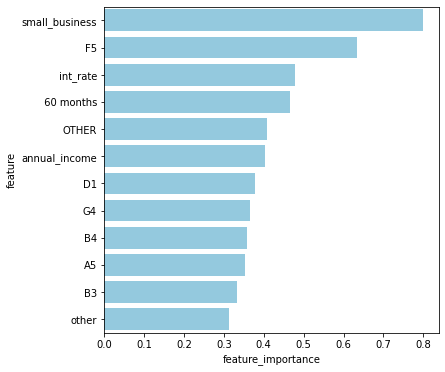

In [39]:
plt.figure(figsize=(6,6))
sns.barplot(x="feature_importance", y="feature", data=feature_importance_top12,color = 'skyblue',order=feature_importance_top12.sort_values('feature_importance',ascending=False).feature)
plt.show()

Besides this model telling us what features have a heavier impact on whether someone is going to default or not, we can also use this information to identify the probability that someone is going to default or not. As the model I chose still predicts a lot of false defaulters, who would actually pay for their loan, this information can be used as a cross check. For example if a member only has a few or none of the above features, the probability that that member is going to default is a lot smaller than for someone who has the majority of the features above. So I recommend LC to cross check the above features with the members. If they only match a few, they could consider giving them the loan as the probabilty they are going to default is a lot smaller than for others. This way they can minimize the amount of defaults while not missing out on a big amount of good loans as well. A situation where the LC can maintain trust and build a good reputation while optimizing their revenue, will be created here.

## In summarry & answering the research question

If an applicant applies for a loan and has the following features:

- Small Business
- Interest rate higher than 12%
- Asks for a term of 60 months
- Does not own a house, mortgage or rents a house
- An income lower than 70.000 dollars
- A purpose that is not classified under the known purpose values
- Get’s classified for either a F5, D1, G4, B4, A5, or B3 grade

The change of a default is very high! 


If they have none or little of these features, the change of a default is smaller.
